In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
try:
    %matplotlib widget
except:
    print("Matplotlib widget not available")

In [3]:
import os
import numpy as np
import pycolmap
import matplotlib.pyplot as plt
from matplotlib.image import imread

from megadepth.utils.projections import backward_project, forward_project
from megadepth.utils.utils import camera_pixel_grid
from megadepth.utils.read_write_dense import read_array

In [4]:
dense_model_dir = os.path.join("..", "data", "south-building", "dense", "colmap")

image_dir = os.path.join(dense_model_dir, "images")
depth_map_dir = os.path.join(dense_model_dir, "stereo", "depth_maps")

reconstruction = pycolmap.Reconstruction(os.path.join(dense_model_dir, "sparse"))
images = reconstruction.images
cameras = reconstruction.cameras
point3D = reconstruction.points3D

In [5]:
id_1 = 26
id_2 = 100

generate_graphs = True
downsample = 10

In [6]:
image1 = images[id_1]
image2 = images[id_2]

camera1 = cameras[image1.camera_id]
camera2 = cameras[image2.camera_id]

In [7]:
depth1 = read_array(os.path.join(depth_map_dir, f"{image1.name}.geometric.bin"))
colors1 = imread(os.path.join(image_dir, image1.name))
depth2 = read_array(os.path.join(depth_map_dir, f"{image2.name}.geometric.bin"))
colors2 = imread(os.path.join(image_dir, image2.name))

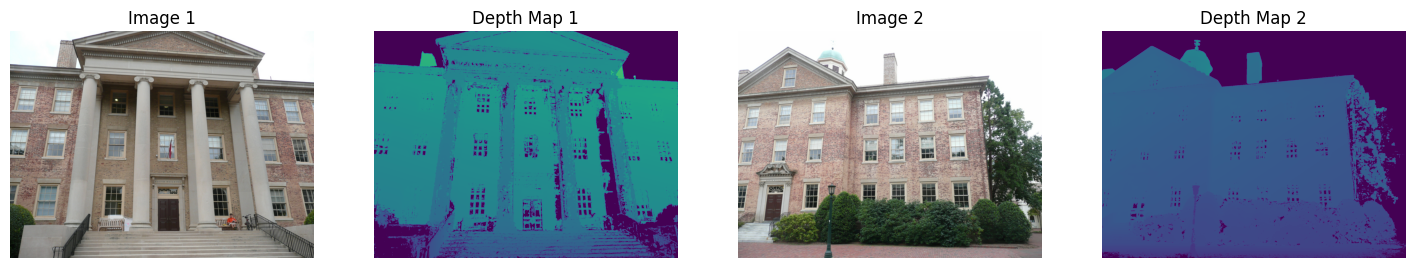

In [8]:
def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(18, 24))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])
 
    plt.show()

plot_images([colors1, depth1, colors2, depth2], ["Image 1", "Depth Map 1", "Image 2", "Depth Map 2"])

# Backward Projection Example

In [9]:
depth1_d = depth1[::downsample, ::downsample]
depth2_d = depth2[::downsample, ::downsample]

world_p1 = backward_project(camera_pixel_grid(camera1, downsample), image1, camera1, depth1_d)
world_p2 = backward_project(camera_pixel_grid(camera1, downsample), image2, camera2, depth2_d)

colors1_d = colors1[::downsample, ::downsample].reshape(-1, 3)
colors2_d = colors2[::downsample, ::downsample].reshape(-1, 3)

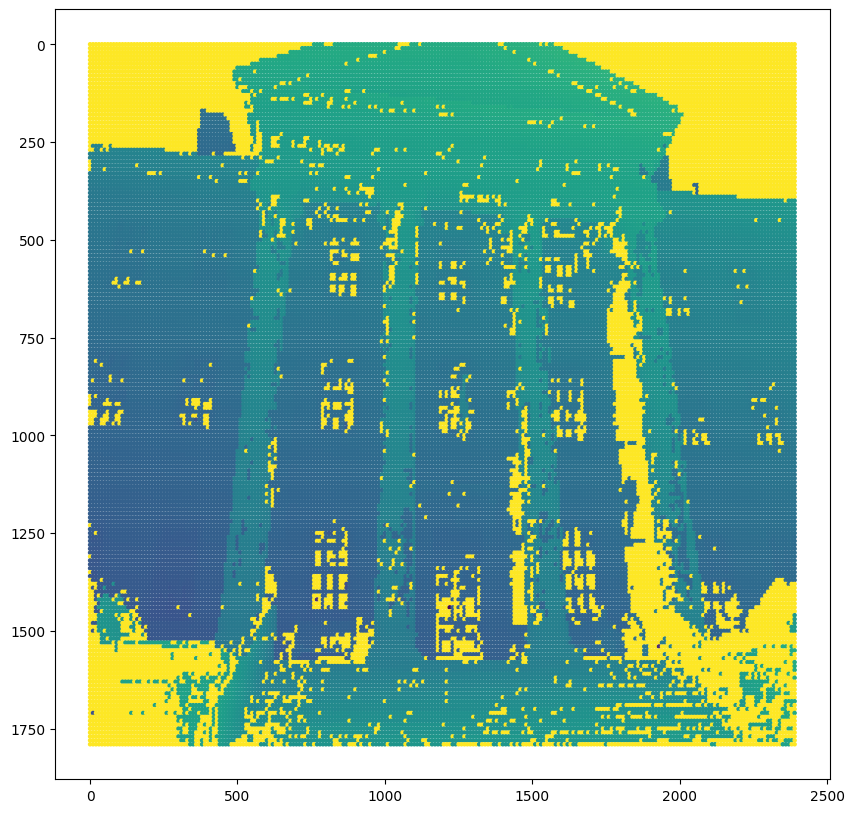

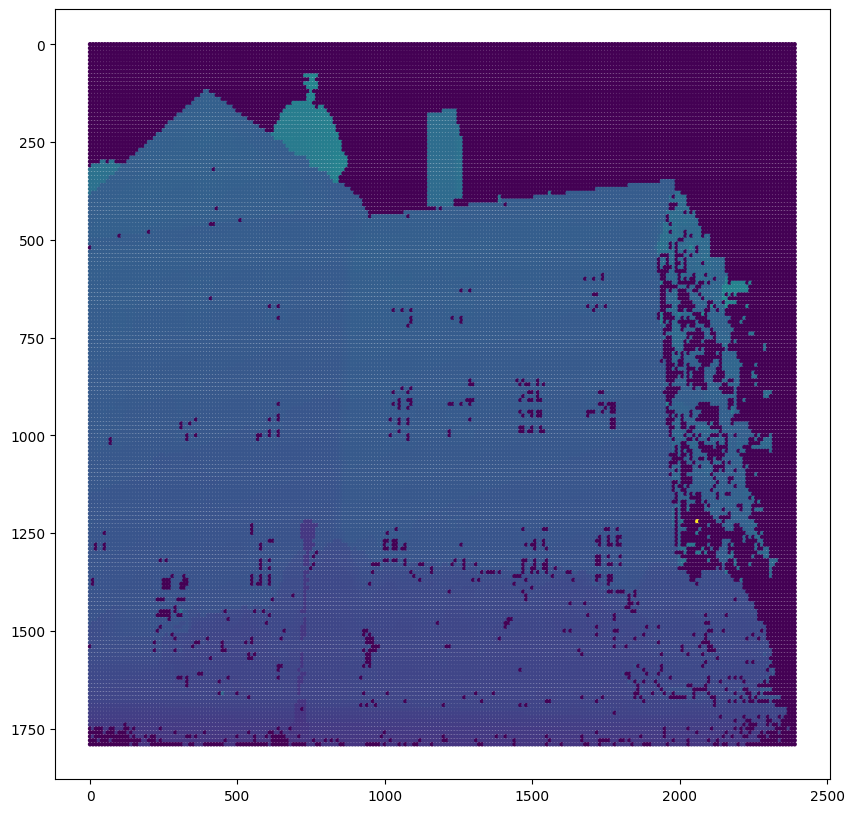

In [10]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    xy1 = camera_pixel_grid(camera1, downsample)
    plt.gca().invert_yaxis()
    ax.scatter(xy1[:, 0], xy1[:, 1], c = world_p1[:, 2], s = 5)
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    xy2 = camera_pixel_grid(camera2, downsample)
    plt.gca().invert_yaxis()
    ax.scatter(xy2[:, 0], xy2[:, 1], c = world_p2[:, 2], s = 5)
    plt.show()

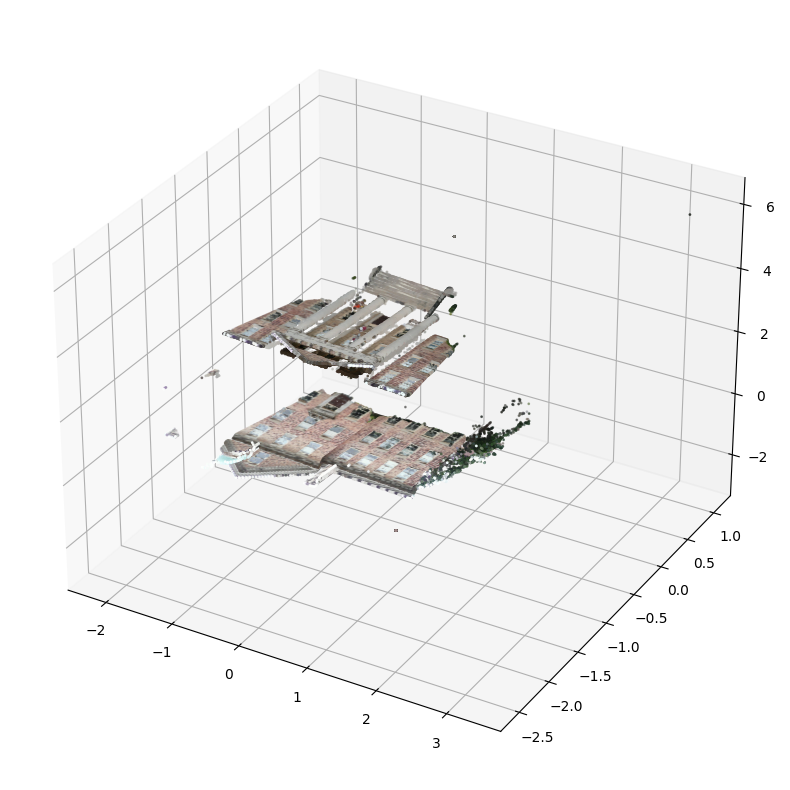

In [11]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

    ax.scatter(world_p1[:, 0], world_p1[:, 1], world_p1[:, 2], s=1, c = colors1_d / 255)
    ax.scatter(world_p2[:, 0], world_p2[:, 1], world_p2[:, 2], s=1, c = colors2_d / 255)

    plt.show()

# Forward Projection Example

In [12]:
uv1, mask1, re_depth1 = forward_project(world_p1, image2, camera2, return_depth = True)
uv2, mask2, re_depth2 = forward_project(world_p2, image1, camera1, return_depth = True)

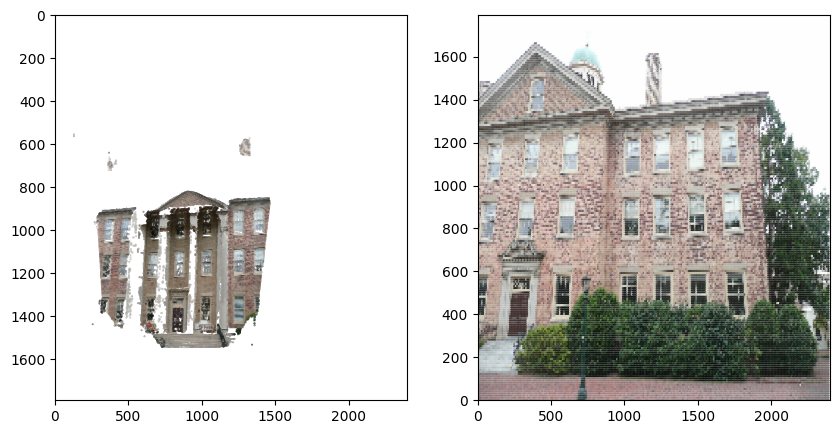

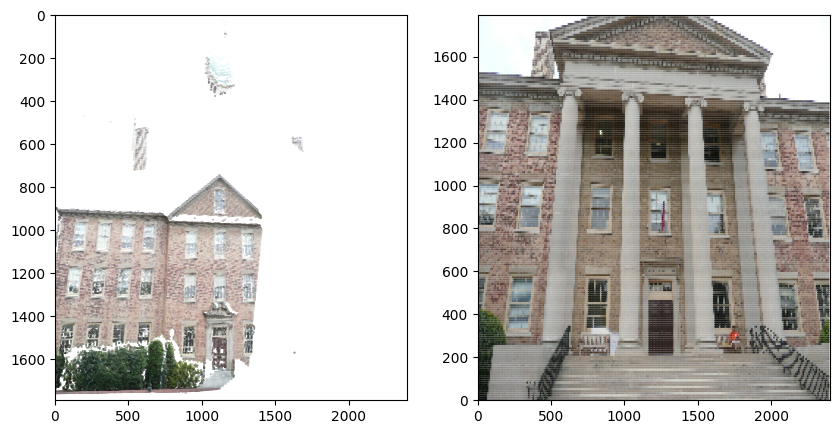

In [13]:
if generate_graphs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_xlim([0, camera2.width])
    ax1.set_ylim([0, camera2.height])
    ax1.invert_yaxis()
    ax1.scatter(uv1[mask1, 0], uv1[mask1, 1], c = colors1_d[mask1, :] / 255, s = 0.1)
    xy2 = camera_pixel_grid(camera2, downsample, reverse_y = True)
    ax2.set_xlim([0, camera2.width])
    ax2.set_ylim([0, camera2.height])
    ax2.scatter(xy2[:, 0], xy2[:, 1], c = colors2_d / 255, s = 0.5)
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_xlim([0, camera1.width])
    ax1.set_ylim([0, camera1.height])
    ax1.invert_yaxis()
    ax1.scatter(uv2[mask2, 0], uv2[mask2, 1], c = colors2_d[mask2, :] / 255, s = 0.1)
    xy1 = camera_pixel_grid(camera1, downsample, reverse_y = True)
    ax2.set_xlim([0, camera1.width])
    ax2.set_ylim([0, camera1.height])
    ax2.scatter(xy1[:, 0], xy1[:, 1], c = colors1_d / 255, s = 0.5)
    plt.show()

## Depth Error

In [14]:
depth_errors1 = np.abs(depth2[::downsample, ::downsample].ravel() - re_depth1)
depth_errors2 = np.abs(depth1[::downsample, ::downsample].ravel() - re_depth2)

In [15]:
inliner1 = depth_errors1<0.5
score1 = np.count_nonzero(inliner1)*downsample*downsample/camera1.width/camera1.height

inliner2 = depth_errors2<0.5
score2 = np.count_nonzero(inliner2)*downsample*downsample/camera2.width/camera2.height

In [16]:
print(np.count_nonzero(depth_errors1<0.05))
print(np.count_nonzero(depth_errors1>0.05))

0
43200


In [17]:
print(score1)
print(score2)

0.0
0.0022541364565904446


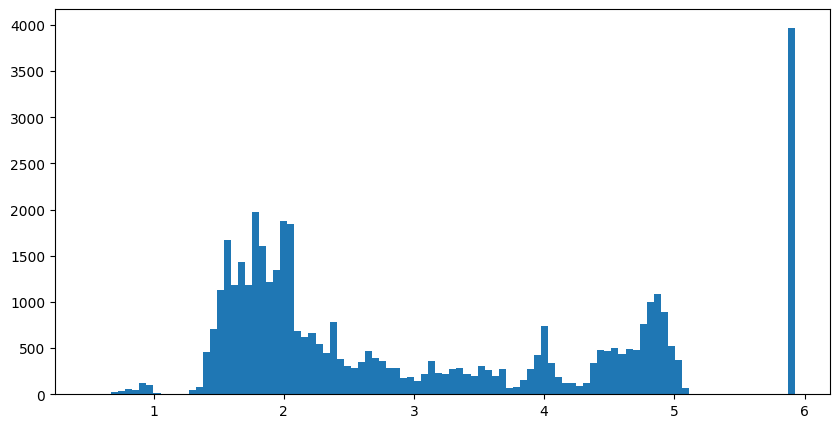

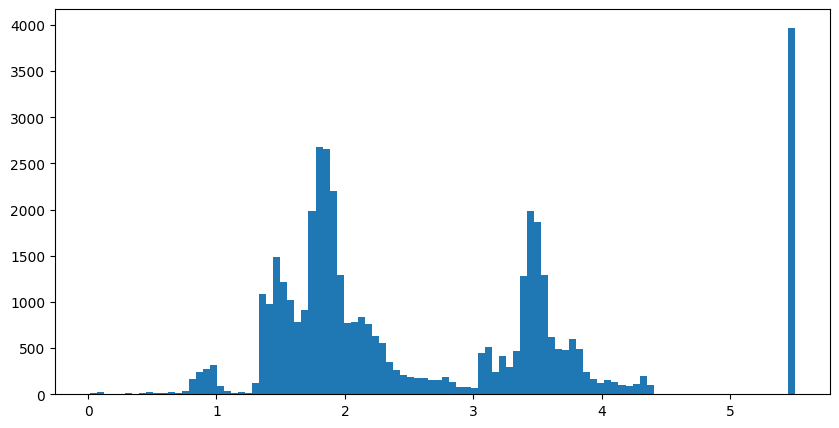

In [18]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(depth_errors1,bins=100)
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(depth_errors2,bins=100)
    plt.show()

# Reprojection Error

In [19]:
xy = camera_pixel_grid(camera1, downsample)

depth1_d = depth1[::downsample, ::downsample]
colors_d = colors1[::downsample, ::downsample].reshape(-1, 3)

world_p1 = backward_project(xy, image1, camera1, depth1_d)

p1_to_im2, mask, re_depth = forward_project(world_p1, image2, camera2, return_depth = True)
re_world_p1 = backward_project(p1_to_im2, image2, camera2, re_depth)
reproj_p1, mask2 = forward_project(re_world_p1, image1, camera1, return_depth = False)

In [20]:
xy.shape

(43200, 2)

In [21]:
reproj_p1.shape

(43200, 2)

In [22]:
# l1 (Manhattan distance) between original and reprojected
reproj_diff = np.abs(xy - reproj_p1).sum(axis = 1)
# l2 (Euler distance) between original and reprojected
#reproj_diff = np.sqrt(np.power(xy - reproj_p1, 2).sum(axis = 1))

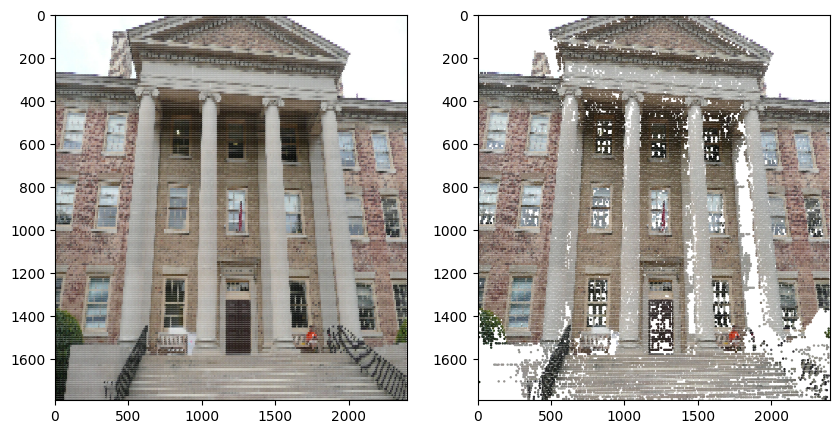

In [23]:
if generate_graphs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_xlim([0, camera1.width])
    ax1.set_ylim([0, camera1.height])
    ax1.invert_yaxis()
    ax1.scatter(xy[:, 0], xy[:, 1], c = colors_d / 255, s = 0.5)
    
    ax2.set_xlim([0, camera2.width])
    ax2.set_ylim([0, camera2.height])
    ax2.invert_yaxis()
    ax2.scatter(reproj_p1[:, 0], reproj_p1[:, 1], c = colors_d / 255, s = 0.5)
    plt.show()

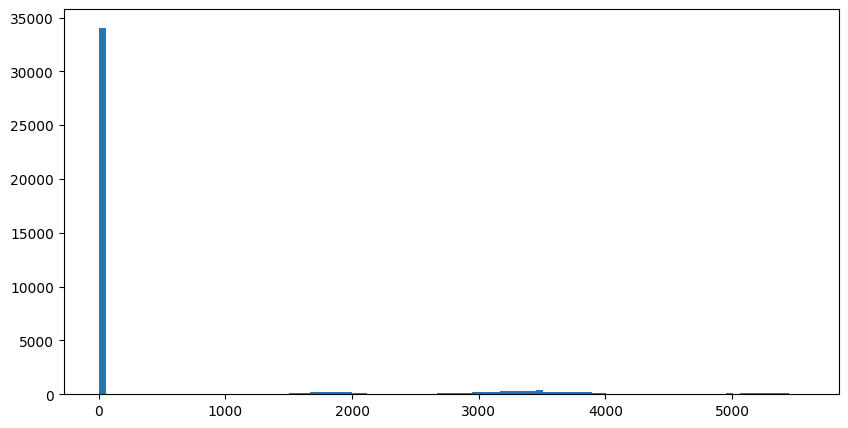

In [24]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(reproj_diff,bins=100)
    plt.show()

In [25]:
inliner = reproj_diff < 2000
score = np.count_nonzero(inliner) / xy.shape[0]

In [26]:
np.count_nonzero(inliner)

35736

In [27]:
print(score)

0.8272222222222222
